<a href="https://colab.research.google.com/github/thnavarro/IPSL-PCM-Tools/blob/main/CDSI_W2_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## ⚠️ Enable GPU on Colab

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

[Reference](https://colab.research.google.com/notebooks/gpu.ipynb)

## ⬇️ Install python packages

In [3]:
# workaround to prevent error when specifying package version.
# see: https://github.com/googlecolab/colabtools/issues/3409
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# install packages, specifying version at time of notebook creation
!pip install -q datasets==2.11
!pip install pyLDAvis==3.4.0
!pip install -q scikit-learn==1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 20.6 MB/s eta 0:00:00


## ↪️ Restart the Notebook

After installing python packages, some packages that were already loaded were updated and in order to correctly use them, we should now restart the notebook.

From the Menu:

Runtime → Restart Runtime

## ➡️ Import python packages

In [1]:
import torch

import datasets as ds
import numpy as np

import json
from tqdm import trange, tqdm

from typing import Dict

# Choose your dataset
Here we download our text data from [huggingface datasets](https://huggingface.co/datasets). We've included several potential datasets (in the domains of news, customer reviews and scientific articles) for you to choose from for this tutorial.

As these datasets can get quite large, we only load `max_documents` examples from the dataset, and use shuffling to ensure a random sample.

`shuffle_seed` enables us to deterministically reload the same random sample by providing the same seed, or to load a different sample by providing a different seed.

In [39]:
# set the dataset parameters on the right
dataset = "yelp_review_full" #@param ["ag_news", "yelp_review_full", "suolyer/pile_pubmed-abstracts"]
max_documents = 1000  #@param {type:"integer"}
shuffle_seed = 42     #@param {type:"integer"}

# load dataset in streaming mode
# this prevents us from downloading entire datasets
# when these can get quite large
dataset = ds.load_dataset(dataset, streaming=True)
split = list(dataset.keys())[0]
buffer_size = max_documents*10
dataset = dataset[split]
dataset = dataset.shuffle(seed=shuffle_seed, buffer_size=buffer_size)
examples = [x for x,_ in zip(dataset, range(max_documents))]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
# let's look at one example to see what the data looks like
print(json.dumps(examples[0], indent=2))

{
  "label": 2,
  "text": "Daniel Fast friendly restaurant with good food. Stopped for an early supper before Saturday night church service after searching Yelp for vegan restaurant options. Food was good, service was good, price was very reasonable. Think I just found a new Saturday evening supper spot."
}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
# in the basic case, we preprocess examples simply by extracting the text field
# (preprocessing examples is different than preprocessing the text)
# Note: the text_field might be named differently for different datasets,
# or the text might be split into multiple fields (e.g. title, abstract)

def preprocess_example(example: Dict, text_field="text") -> str:
  return example[text_field]

documents = [preprocess_example(x) for x in tqdm(examples, desc="Preprocessing examples")]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Preprocessing examples: 100%|██████████| 1000/1000 [00:00<00:00, 753152.09it/s]


In [42]:
# let's look at the same example as before, but now as a document
print(documents[0])

Daniel Fast friendly restaurant with good food. Stopped for an early supper before Saturday night church service after searching Yelp for vegan restaurant options. Food was good, service was good, price was very reasonable. Think I just found a new Saturday evening supper spot.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Pre-Processing

We perform the following steps:

- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Remove stopwords: remove a set of commonly used words such as "the", "and", "is".
- Lemmatization: words in third person are changed to first person and verbs in past and future tenses are changed into present.
- Stemming: words are reduced to their root form.

In [43]:
import nltk
import string
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
text_sample = documents[0].lower()
print(text_sample)
text_p = "".join([char for char in text_sample if char not in string.punctuation])

daniel fast friendly restaurant with good food. stopped for an early supper before saturday night church service after searching yelp for vegan restaurant options. food was good, service was good, price was very reasonable. think i just found a new saturday evening supper spot.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Tokenization


In [45]:
print(" Step 1: Tokenization")
words = word_tokenize(text_p)
print(words)

 Step 1: Tokenization
['daniel', 'fast', 'friendly', 'restaurant', 'with', 'good', 'food', 'stopped', 'for', 'an', 'early', 'supper', 'before', 'saturday', 'night', 'church', 'service', 'after', 'searching', 'yelp', 'for', 'vegan', 'restaurant', 'options', 'food', 'was', 'good', 'service', 'was', 'good', 'price', 'was', 'very', 'reasonable', 'think', 'i', 'just', 'found', 'a', 'new', 'saturday', 'evening', 'supper', 'spot']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Stopwords filtering

In [46]:
print(" Step 2: Remove stopwords")
stop_words = stopwords.words('english')
filtered_words = [word for word in words if word not in stop_words]
print(filtered_words)

 Step 2: Remove stopwords
['daniel', 'fast', 'friendly', 'restaurant', 'good', 'food', 'stopped', 'early', 'supper', 'saturday', 'night', 'church', 'service', 'searching', 'yelp', 'vegan', 'restaurant', 'options', 'food', 'good', 'service', 'good', 'price', 'reasonable', 'think', 'found', 'new', 'saturday', 'evening', 'supper', 'spot']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Lemmatization

In [47]:
print(" Step 3: Lemmatization")
lemmatized_words = [WordNetLemmatizer().lemmatize(word, pos='v') for word in filtered_words]
print(lemmatized_words)

 Step 3: Lemmatization
['daniel', 'fast', 'friendly', 'restaurant', 'good', 'food', 'stop', 'early', 'supper', 'saturday', 'night', 'church', 'service', 'search', 'yelp', 'vegan', 'restaurant', 'options', 'food', 'good', 'service', 'good', 'price', 'reasonable', 'think', 'find', 'new', 'saturday', 'even', 'supper', 'spot']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Stemming

In [48]:
# Stemming
print(" Step 4: Stemming")
porter = PorterStemmer()
stemmed = [porter.stem(word) for word in lemmatized_words]
print(stemmed)

 Step 4: Stemming
['daniel', 'fast', 'friendli', 'restaur', 'good', 'food', 'stop', 'earli', 'supper', 'saturday', 'night', 'church', 'servic', 'search', 'yelp', 'vegan', 'restaur', 'option', 'food', 'good', 'servic', 'good', 'price', 'reason', 'think', 'find', 'new', 'saturday', 'even', 'supper', 'spot']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Pre-process the Dataset

In [49]:
# Apply all pre-processing steps to the entire dataset
def clean_text(text):
  le=WordNetLemmatizer()
  lower_text = text.lower()
  punct_text = "".join([char for char in lower_text if char not in string.punctuation])
  word_tokens=word_tokenize(punct_text)
  tokens=[le.lemmatize(w) for w in word_tokens if w not in stop_words]
  cleaned_text=" ".join(tokens)
  return cleaned_text
cleaned_documents = [clean_text(doc) for doc in documents]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Example

In [50]:
ii=100
print(len(documents))
print("####Original\n")
print(documents[ii])
print("\n ####Cleaned \n")
print(cleaned_documents[ii])


1000
####Original

First of all it must be said that this is a JAPANESE-style sushi house. If you are new to sushi or the Japanese culture, this will not be the restaurant for you. \n\nJapanese style means that when you need a drink refill or want to order something extra, you must wave down the waiters as is the culture in Japan. Americans and we southerner's especially, are not used to this type of service. This is why most of the people that eat in this restaurant are Japanese. If you eat lunch between 1-2PM you will have better service.\n\nThe food is also VERY Japanese. The emphasis is on the fresh fish and the rice. If you are not accustomed to Japanese food, then you may want a non-Japanese sushi bar like Sushi-101 (Mexican made) or Rusan's (Indonesian made) or several others in Charlotte which are Chinese. You will find many varieties of fried sushi with sugary mayo in these locations if that's your idea of sushi.\n\nI have eaten here every week for years. It is a small restaur

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Text Representation

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

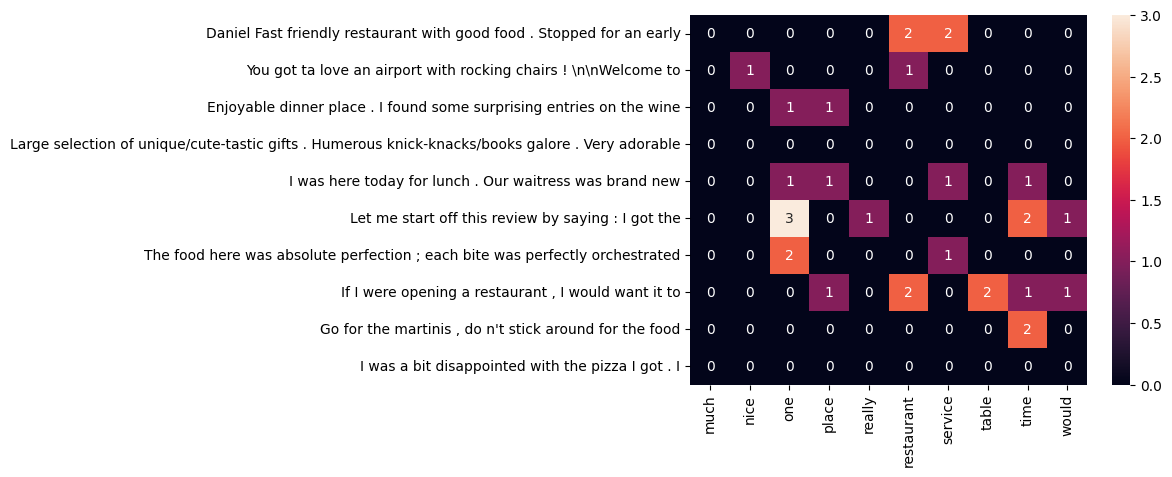

In [51]:
# import packages
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import seaborn as sns
import random
#Get the first sentence
first_sentences = [" ".join(word_tokenize(doc)[:12]) for doc in documents]

# representation with visualization
tf_vectorizer = CountVectorizer(max_features=20)
tf = tf_vectorizer.fit_transform(cleaned_documents)
tf_feature_names = tf_vectorizer.get_feature_names_out()


vect_text_pd = pd.DataFrame(tf.toarray(), columns=tf_feature_names)
vect_text_pd.index = first_sentences
sns.heatmap(vect_text_pd.iloc[:10,-10:], annot=True)



In [52]:
# representation for topic modeling
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(cleaned_documents)
tf_feature_names = tf_vectorizer.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
# function to show topics
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic Modeling with LSA


In [54]:
no_topics = 5 #@param {type:"integer"}

no_top_words = 10 #@param {type:"integer"}

no_top_documents = 3 #@param {type:"integer"}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
from sklearn.decomposition import TruncatedSVD
# SVD to reduce dimensionality:
lsa_model = TruncatedSVD(n_components=no_topics,
                         algorithm='randomized',
                         n_iter=10, random_state=42)
# pipeline of tf-idf + SVD, fit to and applied to documents:
lsa_top=lsa_model.fit(tf)
# Get the right singular vectors of the input data.
components= lsa_top.components_


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


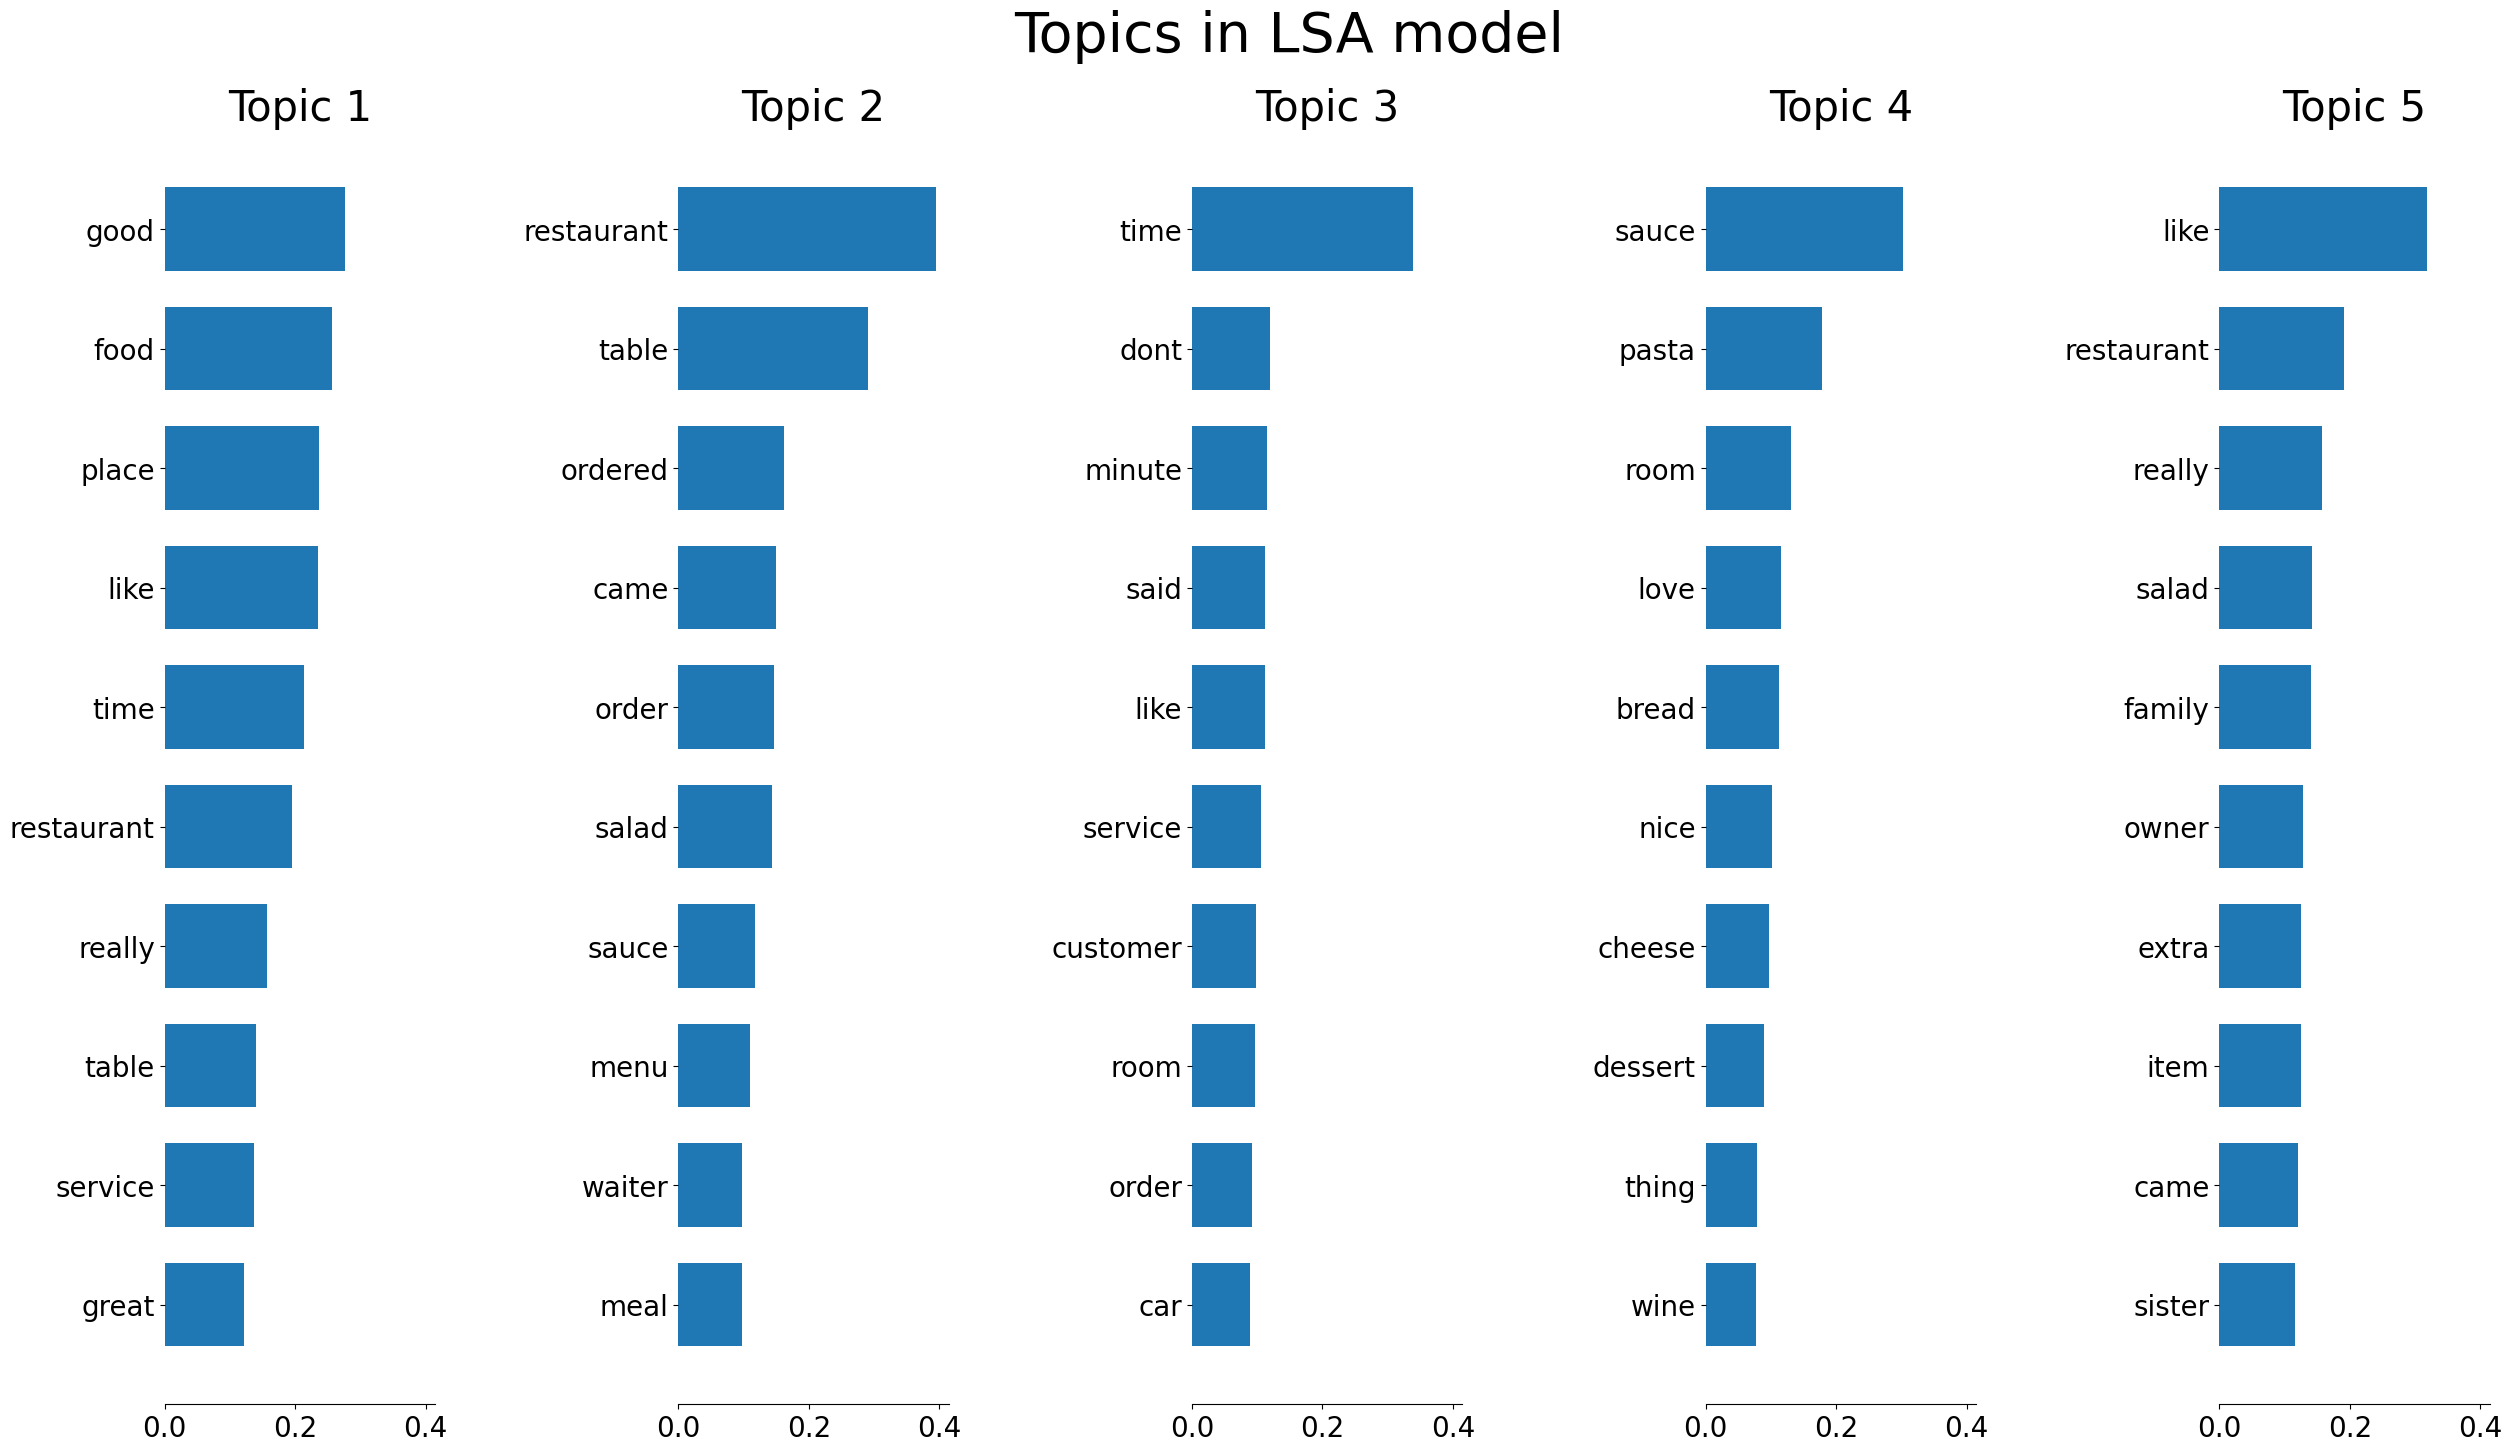

In [56]:
plot_top_words(
    lsa_top, tf_feature_names, no_top_words, "Topics in LSA model"
)

# Topic Modeling with LDA

In [57]:
# Load modules and set parameters

from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

no_topics = 5 #@param {type:"integer"}

no_top_words = 10 #@param {type:"integer"}

no_top_documents = 3 #@param {type:"integer"}



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([ (feature_names[i] + " (" + str(topic[i].round(2)) + ")")
          for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(str(doc_index) + ". " + documents[doc_index])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDA Topics


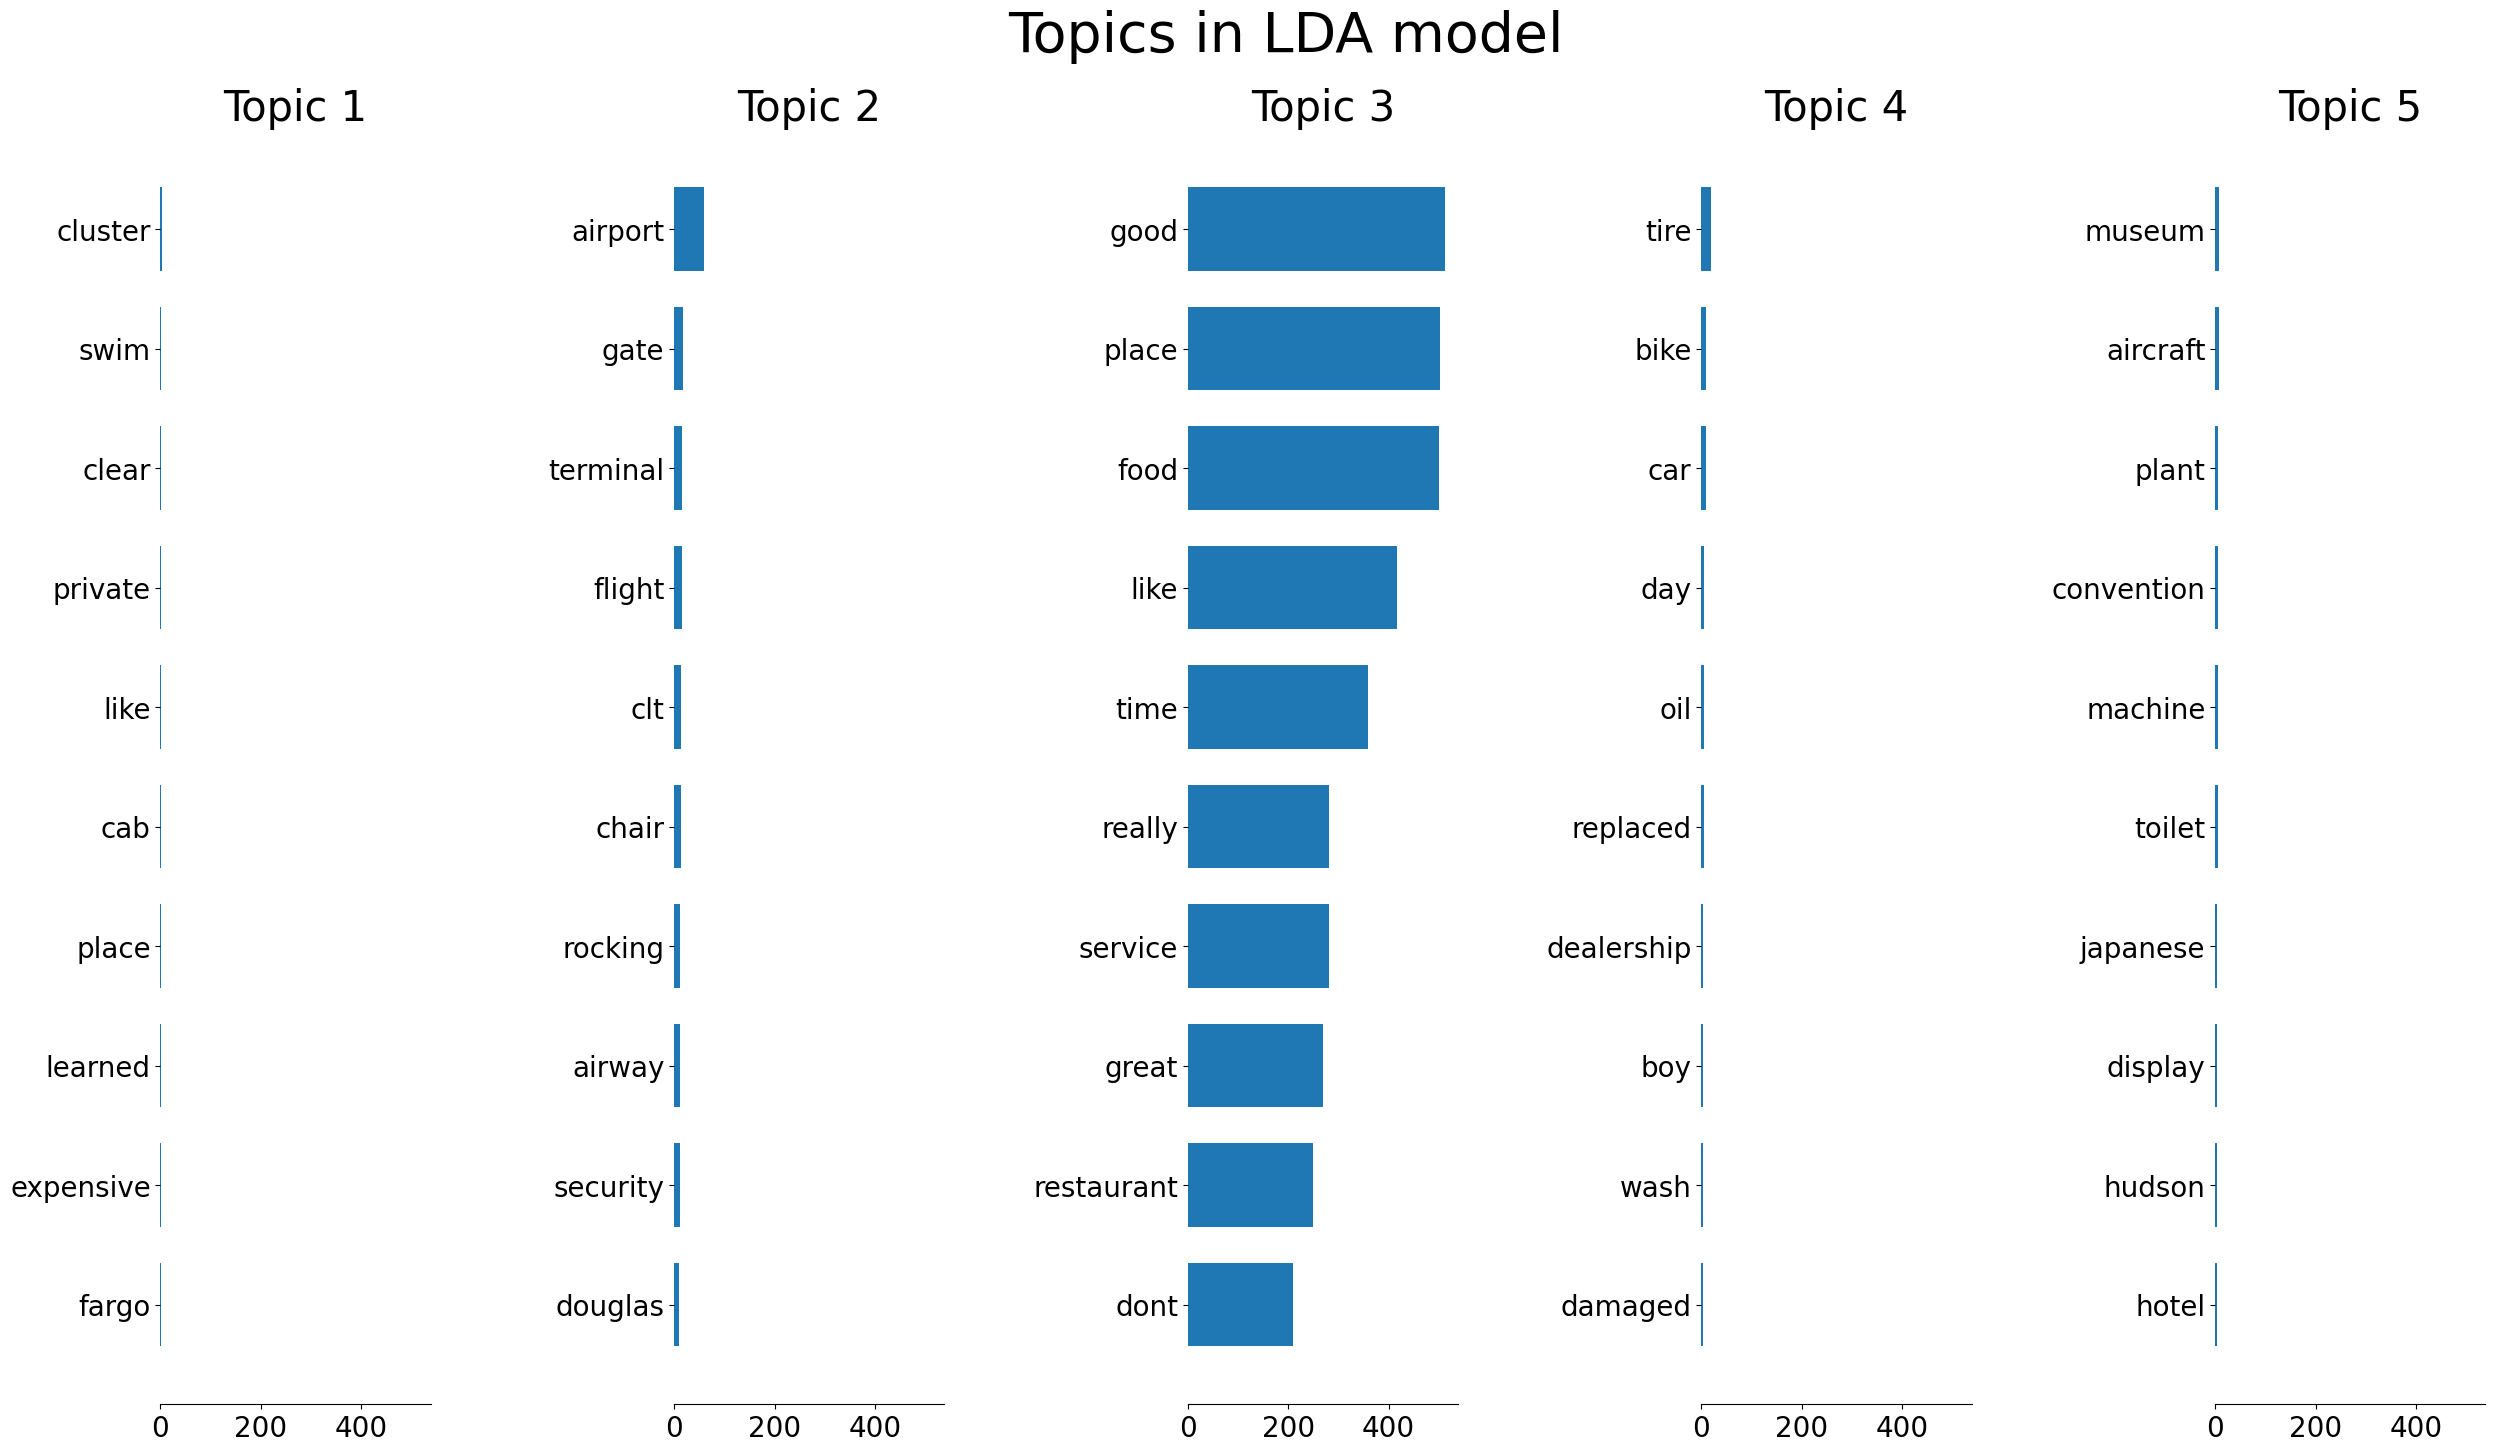

In [59]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
# Run LDA
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.fit(tf)
lda_H = lda_model.components_

print("LDA Topics")
plot_top_words(
    lda_W, tf_feature_names, no_top_words, "Topics in LDA model"
)

In [60]:
# Visualise the results
#@title Visualise LDA with pyLDAVis

import pyLDAvis.lda_model

pyLDAvis.enable_notebook()

pyLDAvis_data = pyLDAvis.lda_model.prepare(lda_model, tf, tf_vectorizer)
# Visualization can be displayed in the notebook
pyLDAvis.display(pyLDAvis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## Topic Classification for New Documents

In [62]:
data_samples = ["Canada has hosted the Summer Olympic Games once, in 1976 in Montreal, Quebec",
                "Announcing updates to Microsoft Cloud for Healthcare in an airport"] #in Iraq
# Vectorize the new data
vec_data = tf_vectorizer.transform(data_samples)

# transform method returns a matrix with one line per document, columns being topics weight
predict = lda_model.transform(vec_data)
topics = np.argmax(predict,axis=1)
print("Predicted topics")
for idx,data_s in enumerate(data_samples):
  print(data_samples[idx],"--> Topic: ",topics[idx],'\n')


Predicted topics
Canada has hosted the Summer Olympic Games once, in 1976 in Montreal, Quebec --> Topic:  0 

Announcing updates to Microsoft Cloud for Healthcare in an airport --> Topic:  1 



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
